# Visualize the cross correlation response map for a real PIV images
- Author: Yong Lee (yongli.cv@gmail.com)
- Date: Sep 1st, 2021

/home/yong/miniconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  from ipykernel import kernelapp as app


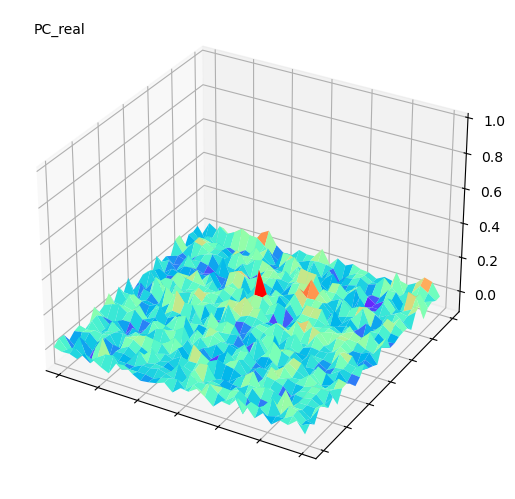

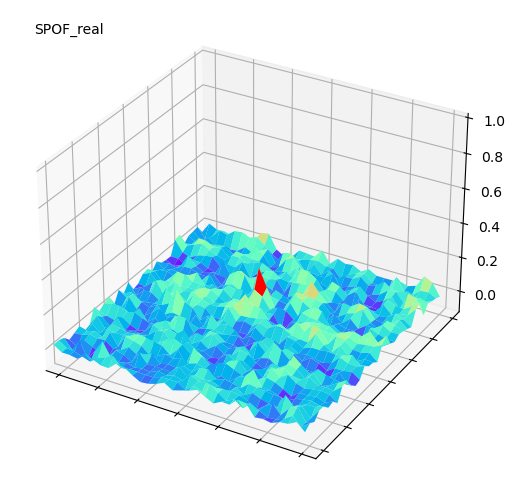

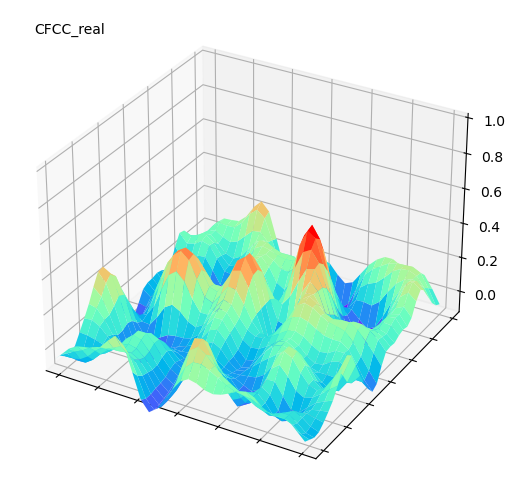

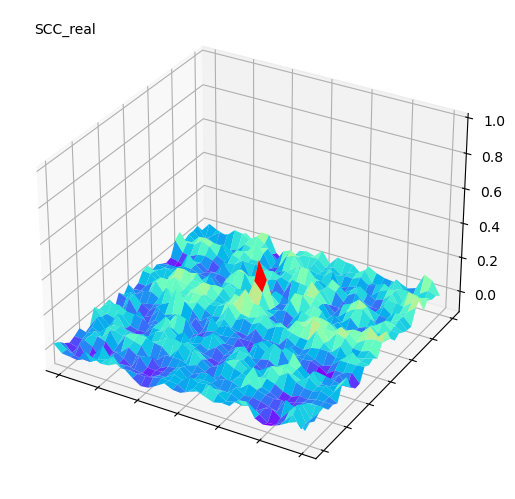

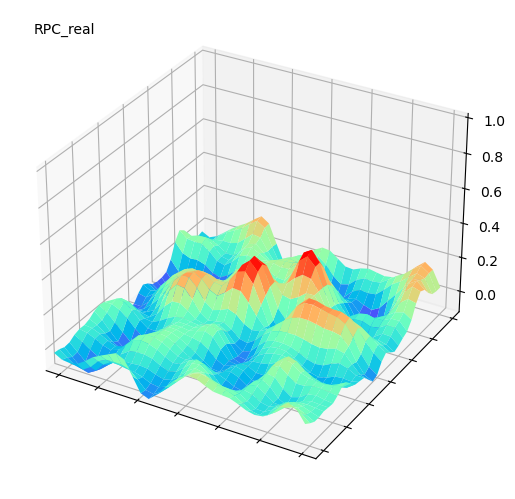

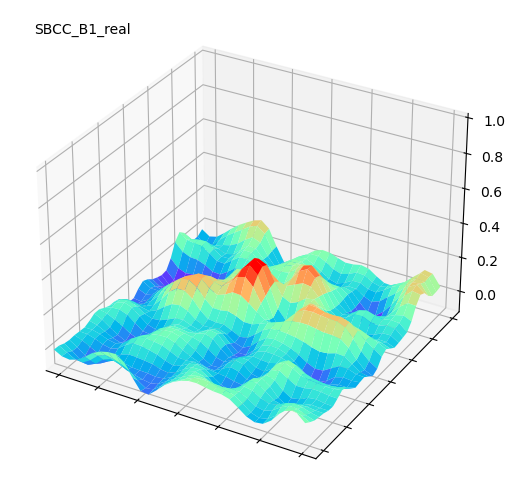

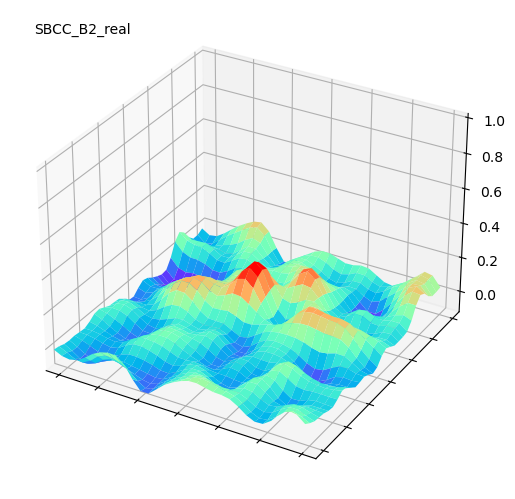

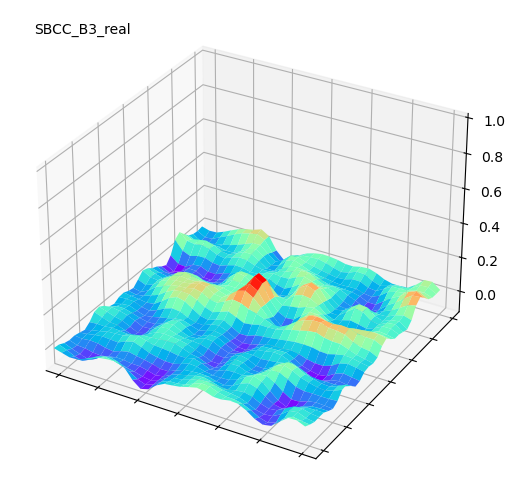

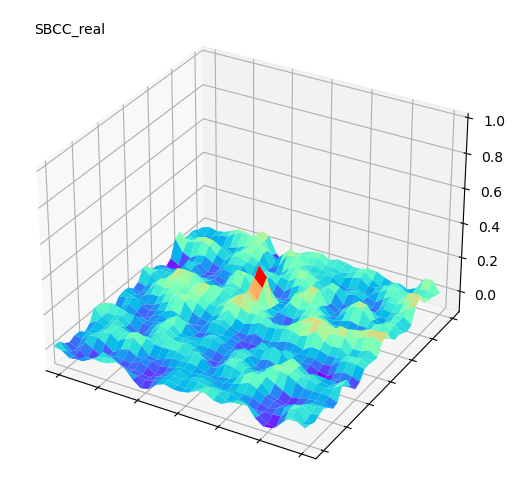

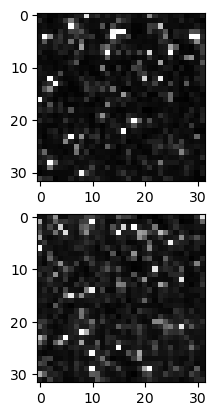

In [1]:
import numpy as np
import cv2
import os
from piv import PIV
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import tool
from utils.outlier import NMT
from utils.plot import plot_cc_map
"""One-pass analysis for PIV with different CC methods"""


def plot_cc_map(r, title):
    fig = plt.figure()
    ax = Axes3D(fig)
    x, y = np.meshgrid(np.arange(0,r.shape[0],1), np.arange(0,r.shape[0],1))
    x, y = x-r.shape[0]//2, y- r.shape[1]//2
    ax.plot_surface(x[:],y[:],r[:], cmap='rainbow')
    ax.set_zlim(-0.1,1.0)
    ax.set_xlim(-16,16)
    ax.set_ylim(-16,16)
    ax.text2D(0.05, 0.95, title, transform=ax.transAxes)
    ax.set_xticklabels([])
    ax.set_yticklabels([])


def plot_field(u, v, method, v_min=0.0, v_max=12.0):
    u =-u.transpose()
    v = v.transpose()
    amp = np.sqrt(u**2+v**2)
    fig = plt.figure()
    plt.imshow(amp, cmap='jet', interpolation='bicubic', vmin=v_min, vmax=v_max)
    ax = fig.gca()
    ax.quiver(u,v, scale=800/(v_max-7.5)) 
    ax.set_title(method)
    ax.axis('equal')
    ax.axis('off')
    plt.colorbar()
    return fig


def main():
    image_lists = [ ['./TestImages/2a.tif', './TestImages/2b.tif']]
    v_max_list = [10] # for visualization control, max value for the vector amplitude 

    method_list  =['pc', 'spof', 'cfcc', 'scc', 'rpc', 'sbcc_b1', 'sbcc_b2', 'sbcc_b3', 'sbcc']
    
    # config for piv 
    config = tool.AttrDict()
    config.win_sz = [32,32]
    config.step_sz =[32,32]
    config.subpixel='gaussian'
    # config.runs= 1 # One-pass method, you also can test the multi-pass method with image deformation

    for k, (file_path, v_max) in enumerate(zip(image_lists, v_max_list)):
        image1 = cv2.imread(file_path[0], 0)
        image2 = cv2.imread(file_path[1], 0)

        # get the "truth" reference for outlier identification
        config.runs = 3
        config.method = 'scc'
        piv = PIV(config)
        u_t, v_t, r_map= piv.compute(image1, image2)
        u_t, v_t, index = NMT(u_t,v_t) # save the data to generate truth, please make config.runs=3

        for method in method_list:
            info = f"{v_max}_{method}"

            config.method = method
            config.runs = 1
            piv = PIV(config)

            u, v, r= piv.compute(image1, image2)

            index = r.shape[-1]//2 - 1
            info = f"{method.upper()}_real"
            fig = plot_cc_map(r[:,:,index], info)
            plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)
            pdf_path = 'output/Fig7_'+info +".pdf"
            svg_path = 'output/Fig7_'+info +".svg"
            # plt.savefig(pdf_path, bbox_inches='tight') # the plt.save has bugs to save as pdf
            plt.savefig(svg_path)
            os.system(f"inkscape {svg_path} --export-pdf={pdf_path}")
            os.system(f"pdfcrop {pdf_path} {pdf_path}")

        win1,_ = piv.grid_window(image1)
        win2,_ = piv.grid_window(image2)
        plt.figure()
        plt.subplot(2,1,1); plt.imshow(win1[:,:,index], cmap='gray')
        plt.subplot(2,1,2); plt.imshow(win2[:,:,index], cmap='gray')
        plt.savefig('output/Fig7_real_image.pdf', bbox_inches='tight') 
        print('\n')

    plt.show()

main()